### 📈 Forecast with Prophet (Facebook's library)

To forecast leads and conversions over the next 3 months, we can use time series forecasting methods such as ARIMA or machine learning-based approaches (e.g., Random Forest or XGBoost), depending on the complexity of the data. The input for these models would include historical lead counts, conversion rates, and other relevant features such as marketing spend or sales activities.

Optimization Recommendations
Budget Allocation: By analyzing which channels are driving high-quality leads, we can recommend optimizing the marketing budget by shifting more focus to the channels with the best ROI.

Campaign Targeting: Segmenting leads based on behavior profiles and enrichment data can help fine-tune targeting strategies for higher conversion rates.

In [175]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import snowflake.connector
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [176]:
# connection parameters
account = 'rv79164.mexico-central.azure'
user = 'anguiegarcia'
password = 'AnguieCobre_2025'
database = 'my_database'
schema = 'my_schema'
warehouse = 'my_warehouse'
role = 'accountadmin'
threads = 1

# Snowflake connection
conn = snowflake.connector.connect(
    user=user,
    password=password,
    account=account,
    database=database,
    schema=schema,
    warehouse=warehouse,
    role=role
)

In [177]:

sql_query = "SELECT * FROM MART_FORECAST_DATA;"
df = pd.read_sql(sql_query, conn)
print(f"shape: {df.shape}")
df.head()

shape: (51, 3)


C:\Users\BETAN\AppData\Local\Temp\ipykernel_23216\72853018.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


,WEEK_START,LEADS_CREATED,WONS_CREATED
0,2017-06-12,3,0
1,2017-06-19,1,0
2,2017-06-26,1,0
3,2017-07-03,42,0
4,2017-07-10,51,2


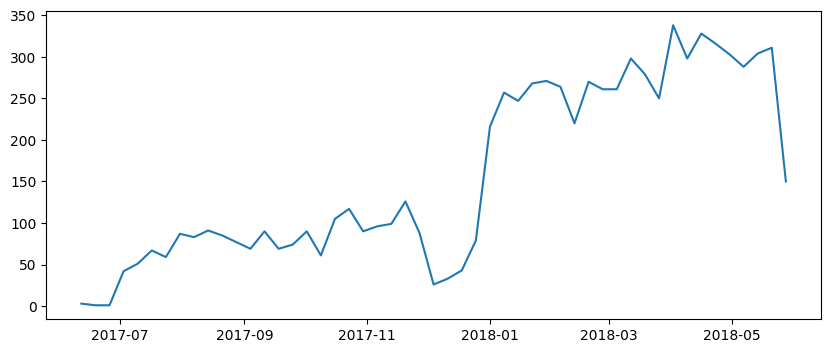

In [178]:
plt.figure(figsize=(10, 4))
plt.plot(df['WEEK_START'], df['LEADS_CREATED'])

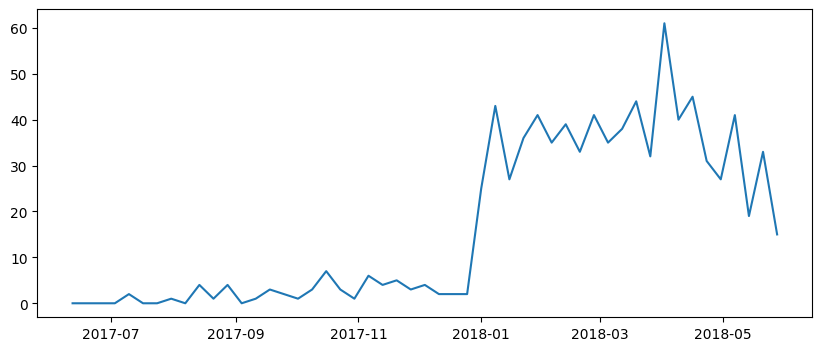

In [179]:
plt.figure(figsize=(10, 4))
plt.plot(df['WEEK_START'], df['WONS_CREATED'])

17:23:46 - cmdstanpy - INFO - Chain [1] start processing
17:23:46 - cmdstanpy - INFO - Chain [1] done processing


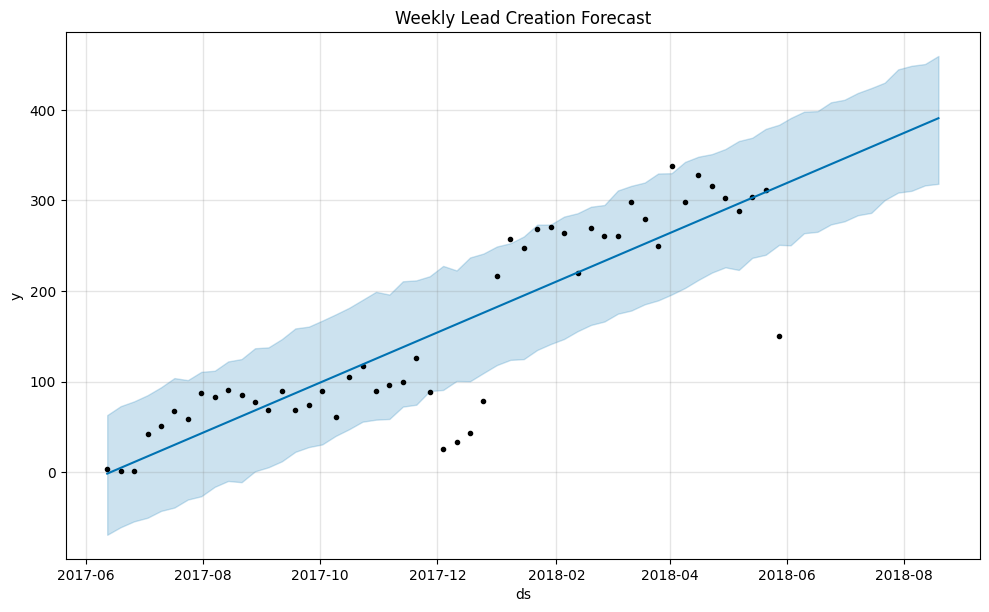

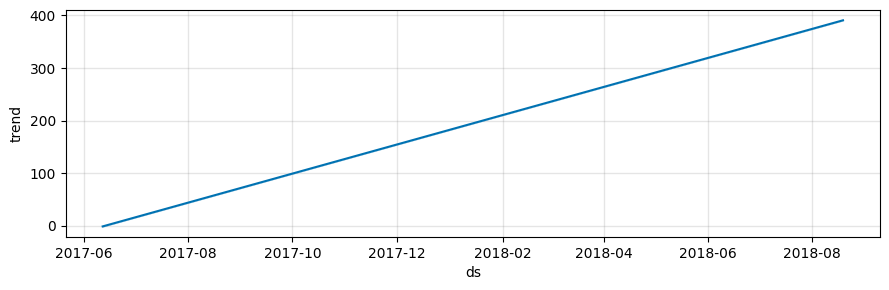

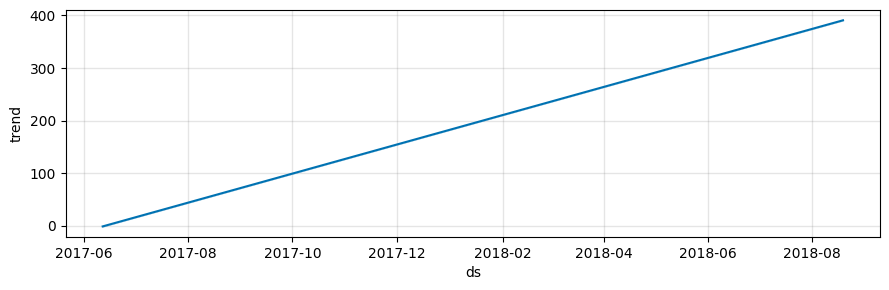

In [180]:
# Load data
df = df.rename(columns={'WEEK_START': 'ds', 'LEADS_CREATED': 'y'})

# Train Prophet model
model = Prophet()
model.fit(df)

# Forecast into the future (e.g., next 12 weeks)
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Weekly Lead Creation Forecast")
plt.show()

#  Plot seasonality
model.plot_components(forecast)



### changepoints 

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [182]:

sql_query = "SELECT * FROM MART_FORECAST_DATA;"
df = pd.read_sql(sql_query, conn)
print(f"shape: {df.shape}")
df.head()

shape: (51, 3)


C:\Users\BETAN\AppData\Local\Temp\ipykernel_23216\72853018.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


,WEEK_START,LEADS_CREATED,WONS_CREATED
0,2017-06-12,3,0
1,2017-06-19,1,0
2,2017-06-26,1,0
3,2017-07-03,42,0
4,2017-07-10,51,2


In [183]:
def forecast_businesscase(df, column1, column2):
    """
    Forecasts based on historical data using Prophet and evaluates the model if test data is available.
    
    Args:
    df (DataFrame): The input dataframe containing the historical data.
    column1 (str): The name of the column containing the dates (e.g., 'WEEK_START').
    column2 (str): The name of the column containing the target variable (e.g., 'LEADS_CREATED').
    
    Returns:
    None
    """
    # Convert the date column to datetime
    df[column1] = pd.to_datetime(df[column1])

    # Rename columns for Prophet
    df_prophet = df.rename(columns={column1: 'ds', column2: 'y'})

    # Split into train/test sets if enough data
    if len(df_prophet) > 12:
        train = df_prophet[:-4]
        test = df_prophet[-4:]
    else:
        train = df_prophet
        test = None

    # Create and train model
    model = Prophet()
    model.fit(train)

    # Predict on test or recent data
    future = test[['ds']] if test is not None else df_prophet[['ds']]
    forecast = model.predict(future)

    # Show predictions
    print("Predictions:")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

    # Plot the forecast
    model.plot(forecast)
    plt.title("Forecast vs Real")
    plt.xlabel("Date")
    plt.ylabel(column2)
    plt.show()

    # Evaluate if test data available
    if test is not None:
        pred = forecast[['ds', 'yhat']].merge(test, on='ds')
        mae = mean_absolute_error(pred['y'], pred['yhat'])
        rmse = np.sqrt(mean_squared_error(pred['y'], pred['yhat']))
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
    else:
        print("Not enough data for model evaluation.")

    # Forecast next 12 weeks
    future = model.make_future_dataframe(periods=12, freq='W')
    forecast = model.predict(future)

    print("Future Predictions:")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(13))

    # Final plot with predicted points
    fig = model.plot(forecast)
    fig.set_size_inches(5, 5)  # ancho x alto en pulgadas

    plt.scatter(forecast['ds'], forecast['yhat'], color='red', label='Predicted Points', s=30)
    plt.title(f"Forecast with Predicted Points {column2}")
    plt.xlabel("Date")
    plt.ylabel(column2)
    plt.legend()
    plt.show()



17:23:47 - cmdstanpy - INFO - Chain [1] start processing
17:23:47 - cmdstanpy - INFO - Chain [1] done processing


Predictions:
          ds        yhat  yhat_lower  yhat_upper
0 2018-05-07  312.441821  248.146127  371.882064
1 2018-05-14  319.302161  259.976027  382.339755
2 2018-05-21  326.162501  259.901468  389.936866
3 2018-05-28  333.022840  264.030687  395.622990


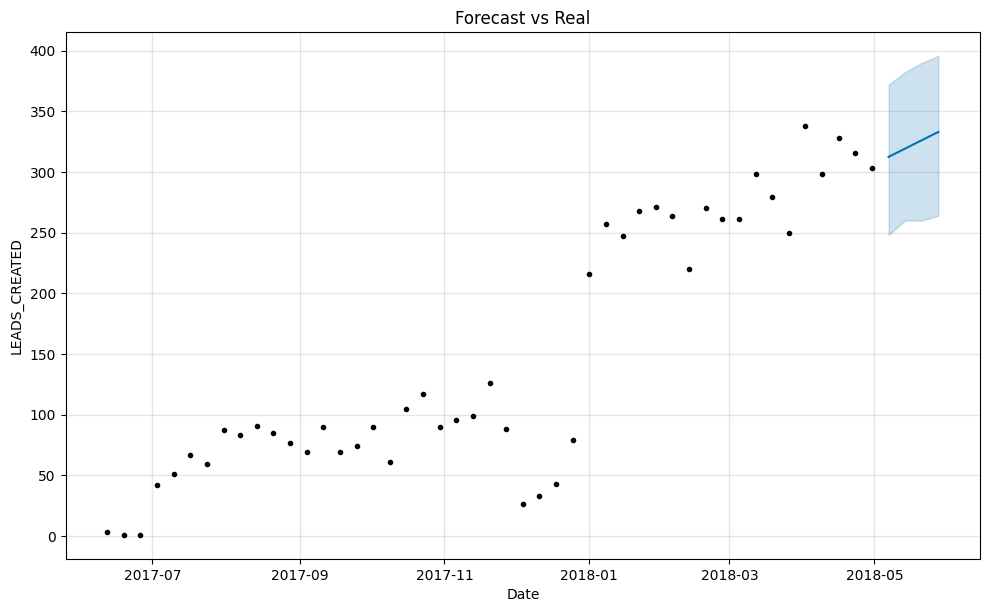

MAE: 59.48
RMSE: 92.95
Future Predictions:
           ds        yhat  yhat_lower  yhat_upper
46 2018-04-30  305.581481  244.658908  367.936774
47 2018-05-06  311.461772  247.526423  373.775640
48 2018-05-13  318.322112  256.930001  378.472999
49 2018-05-20  325.182452  263.154838  389.537906
50 2018-05-27  332.042792  270.514325  391.982193
51 2018-06-03  338.903132  275.520375  397.400309
52 2018-06-10  345.763472  279.995914  411.298584
53 2018-06-17  352.623811  294.354165  417.394955
54 2018-06-24  359.484151  295.928600  425.447892
55 2018-07-01  366.344491  303.721499  431.803278
56 2018-07-08  373.204831  307.530454  435.556660
57 2018-07-15  380.065171  320.907482  444.944366
58 2018-07-22  386.925511  321.915406  448.599151


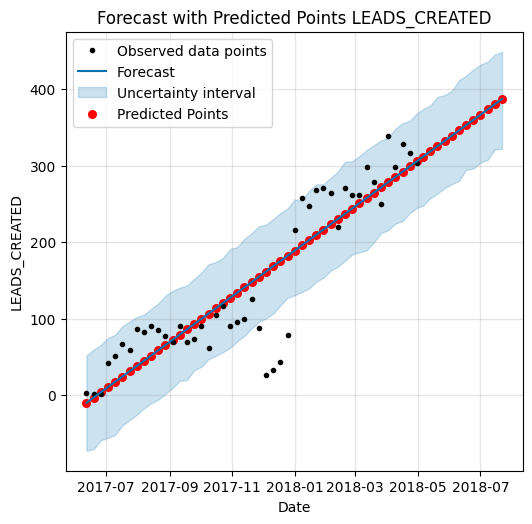

In [184]:
forecast_businesscase(df, 'WEEK_START', 'LEADS_CREATED')

17:23:48 - cmdstanpy - INFO - Chain [1] start processing
17:23:48 - cmdstanpy - INFO - Chain [1] done processing


Predictions:
          ds       yhat  yhat_lower  yhat_upper
0 2018-05-07  42.385499   30.468052   54.516515
1 2018-05-14  43.500616   30.001663   56.701547
2 2018-05-21  44.615733   33.599472   56.208966
3 2018-05-28  45.730850   33.183013   57.420417


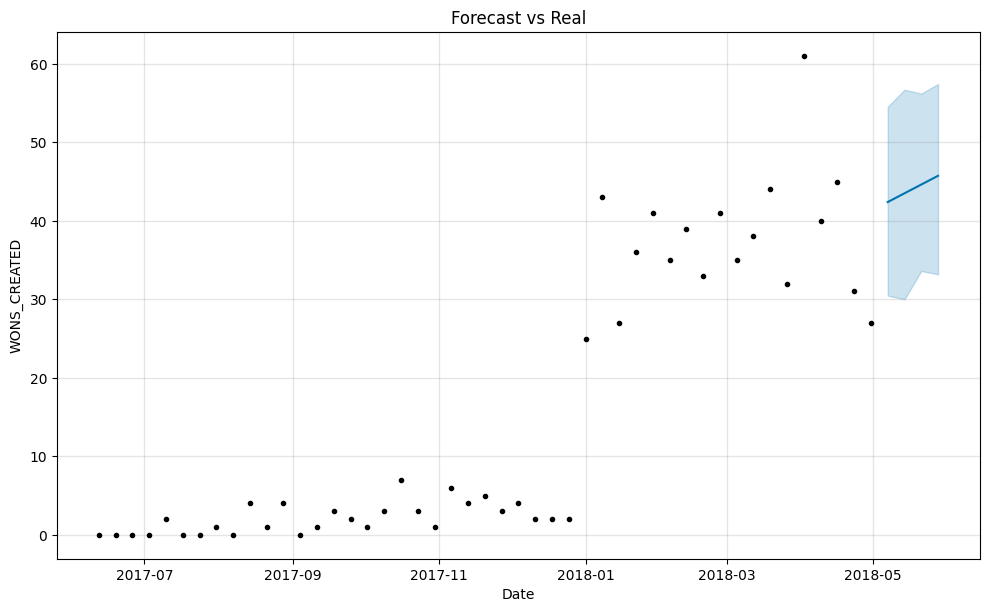

MAE: 17.06
RMSE: 20.50
Future Predictions:
           ds       yhat  yhat_lower  yhat_upper
46 2018-04-30  41.270381   29.053946   53.730956
47 2018-05-06  42.226196   29.147043   55.667219
48 2018-05-13  43.341313   30.513418   55.304592
49 2018-05-20  44.456431   32.558658   56.684342
50 2018-05-27  45.571548   33.569089   57.762364
51 2018-06-03  46.686665   35.020494   59.323063
52 2018-06-10  47.801782   35.924351   60.186471
53 2018-06-17  48.916899   37.425268   61.766485
54 2018-06-24  50.032017   38.705778   61.908280
55 2018-07-01  51.147134   38.494211   63.269092
56 2018-07-08  52.262251   40.065988   64.501796
57 2018-07-15  53.377368   41.003899   64.761188
58 2018-07-22  54.492486   41.846911   67.228766


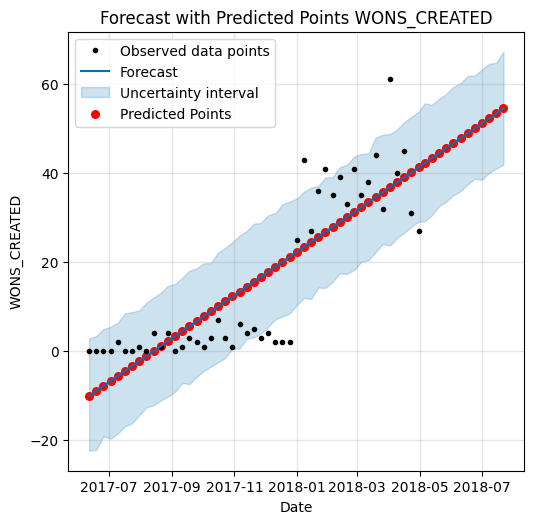

In [185]:
forecast_businesscase(df, 'WEEK_START', 'WONS_CREATED')

📊 Interpretation of the Forecast

- They show some fluctuation but generally follow an upward trend.
- Forecast (blue line): This represents the model's prediction for future values. It continues the upward trend, suggesting increasing leads over time.
- Uncertainty Interval (shaded blue area): This shows the model’s confidence in its predictions. The wider the interval, the more uncertainty the model has. The forecast becomes slightly more uncertain over time, as expected.
- Predicted Points (red dots): These are the specific predicted values over time, which lie on the blue forecast line.

⚠️ Potential Risks and Limitations
- Model Over-Simplification: The nearly linear forecast suggests the model may assume a simple trend without accounting for seasonality, cyclical patterns, or external events (e.g., campaigns, policy changes).
- Uncertainty Increases Over Time: As the forecast extends further into the future, the confidence interval widens, reflecting increased uncertainty. Planning based on long-term forecasts should be done with caution.
- Outliers and Data Gaps: Some observed values (e.g., sudden drops) deviate significantly from the trend. These could indicate missing data, anomalies, or structural changes not captured by the model.
- Assumption of Constant Growth: The model appears to project continuous growth, which may not be realistic indefinitely due to market saturation, budget constraints, or operational limits.
- Lack of Explanatory Variables: The model likely uses only time-based inputs. Including external factors (e.g., ad spend, seasonal events, competitors' actions) might improve accuracy and provide more actionable insights.

#### add variables

In [186]:
from sklearn.model_selection import train_test_split

In [203]:
sql_query = "SELECT * FROM IN_HUBSPOT_LEADS_ENRICHED;"
df = pd.read_sql(sql_query, conn)

df['FIRST_CONTACT_DATE'] = pd.to_datetime(df['FIRST_CONTACT_DATE'])

# Get dummies
dumis = pd.get_dummies(df[['LEAD_SOURCE']], drop_first=True)

df = pd.concat([df, dumis], axis=1)
df=df[['FIRST_CONTACT_DATE','IS_WON','LEAD_SOURCE_display', 'LEAD_SOURCE_email',
       'LEAD_SOURCE_organic_search', 'LEAD_SOURCE_other',
       'LEAD_SOURCE_other_publicities', 'LEAD_SOURCE_paid_search',
       'LEAD_SOURCE_referral', 'LEAD_SOURCE_social', 'LEAD_SOURCE_unknown']]
df.head()

C:\Users\BETAN\AppData\Local\Temp\ipykernel_23216\584134698.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


,FIRST_CONTACT_DATE,IS_WON,LEAD_SOURCE_display,LEAD_SOURCE_email,LEAD_SOURCE_organic_search,LEAD_SOURCE_other,LEAD_SOURCE_other_publicities,LEAD_SOURCE_paid_search,LEAD_SOURCE_referral,LEAD_SOURCE_social,LEAD_SOURCE_unknown
0,2018-02-01,0,False,False,False,False,False,False,False,True,False
1,2017-10-20,0,False,False,False,False,False,True,False,False,False
2,2018-03-22,0,False,False,True,False,False,False,False,False,False
3,2018-01-22,0,False,True,False,False,False,False,False,False,False
4,2018-02-21,1,False,False,True,False,False,False,False,False,False


MAE: 35.61
RMSE: 40.71
MAPE: 12.52


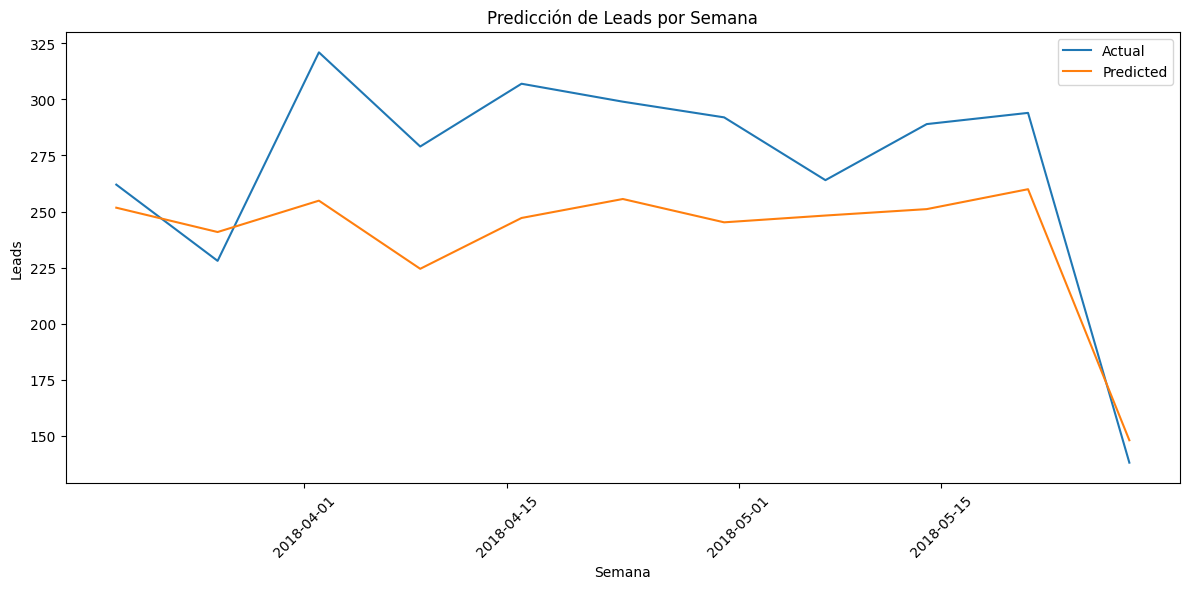

In [204]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Asegurarse de que las columnas booleanas sean de tipo int
source_columns = [col for col in df.columns if col.startswith('LEAD_SOURCE_')]
df[source_columns] = df[source_columns].astype(int)

# Crear una columna de semana
df['WEEK'] = df['FIRST_CONTACT_DATE'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por semana y sumar por cada fuente de lead
weekly_data = df.groupby('WEEK')[source_columns].sum().reset_index()

# La variable objetivo será la suma total de leads por semana
weekly_data['TOTAL_LEADS'] = weekly_data[source_columns].sum(axis=1)

# Separar variables predictoras y target
X = weekly_data[source_columns]
y = weekly_data['TOTAL_LEADS']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Entrenar el modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicción y evaluación
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
print(f"RMSE: {rmse:.2f}")

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}")

# Visualizar resultado
plt.figure(figsize=(12, 6))
plt.plot(weekly_data['WEEK'][-len(y_test):], y_test.values, label='Actual')
plt.plot(weekly_data['WEEK'][-len(y_test):], y_pred, label='Predicted')
plt.xticks(rotation=45)
plt.title("Predicción de Leads por Semana")
plt.xlabel("Semana")
plt.ylabel("Leads")
plt.legend()
plt.tight_layout()
plt.show()


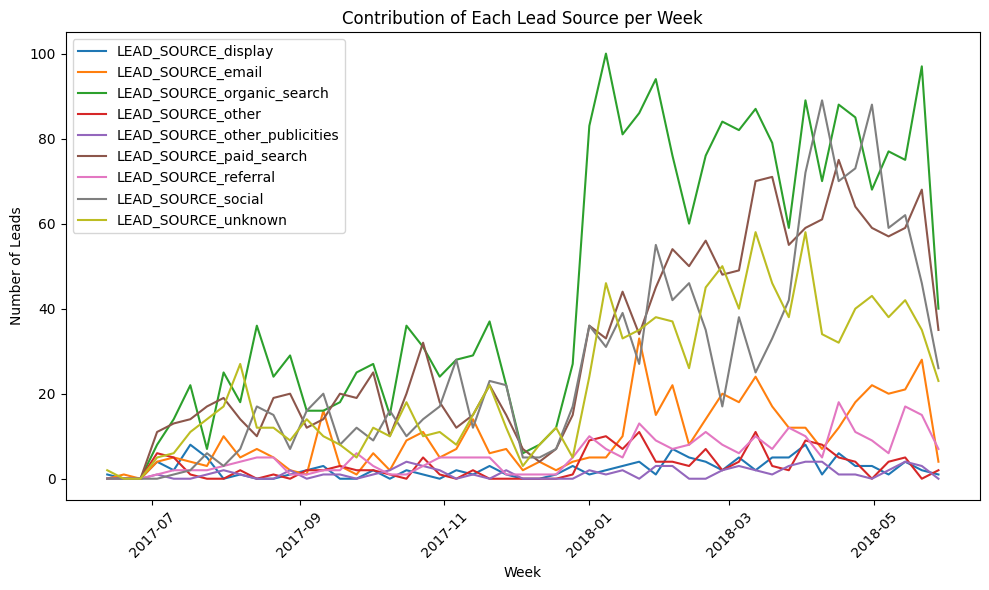

In [199]:
# Visualization of each source's contribution per week
plt.figure(figsize=(10, 6))
for col in source_columns:
    plt.plot(weekly_data['WEEK'], weekly_data[col], label=col)

plt.title("Contribution of Each Lead Source per Week")
plt.xlabel("Week")
plt.ylabel("Number of Leads")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [200]:
# Correlación entre cada fuente y el total de leads
correlation_matrix = weekly_data[source_columns + ['TOTAL_LEADS']].corr()
print(correlation_matrix['TOTAL_LEADS'].sort_values(ascending=False))


TOTAL_LEADS                      1.000000
LEAD_SOURCE_organic_search       0.964622
LEAD_SOURCE_paid_search          0.960034
LEAD_SOURCE_unknown              0.931003
LEAD_SOURCE_social               0.873047
LEAD_SOURCE_referral             0.847593
LEAD_SOURCE_email                0.769496
LEAD_SOURCE_other                0.606325
LEAD_SOURCE_other_publicities    0.502820
LEAD_SOURCE_display              0.492749
Name: TOTAL_LEADS, dtype: float64


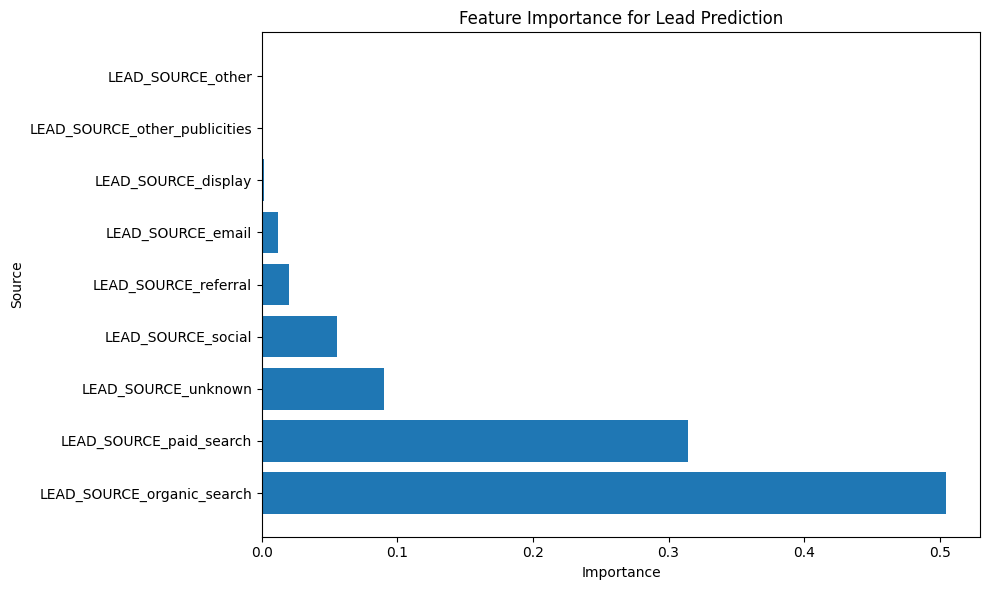

                          Source  Importance
2     LEAD_SOURCE_organic_search    0.504582
5        LEAD_SOURCE_paid_search    0.314653
8            LEAD_SOURCE_unknown    0.090204
7             LEAD_SOURCE_social    0.055432
6           LEAD_SOURCE_referral    0.019687
1              LEAD_SOURCE_email    0.012194
0            LEAD_SOURCE_display    0.001360
4  LEAD_SOURCE_other_publicities    0.001025
3              LEAD_SOURCE_other    0.000864


In [197]:
# Feature importance in the model
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Source': source_columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize the importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Source'], importance_df['Importance'])
plt.title("Feature Importance for Lead Prediction")
plt.xlabel("Importance")
plt.ylabel("Source")
plt.tight_layout()
plt.show()

print(importance_df)


### wons

In [202]:
sql_query = "SELECT * FROM IN_HUBSPOT_LEADS_ENRICHED;"
df = pd.read_sql(sql_query, conn)

df['FIRST_CONTACT_DATE'] = pd.to_datetime(df['FIRST_CONTACT_DATE'])

# Get dummies
dumis = pd.get_dummies(df[['LEAD_SOURCE']], drop_first=True)

df = pd.concat([df, dumis], axis=1)
df=df[['FIRST_CONTACT_DATE','IS_WON','LEAD_SOURCE_display', 'LEAD_SOURCE_email',
       'LEAD_SOURCE_organic_search', 'LEAD_SOURCE_other',
       'LEAD_SOURCE_other_publicities', 'LEAD_SOURCE_paid_search',
       'LEAD_SOURCE_referral', 'LEAD_SOURCE_social', 'LEAD_SOURCE_unknown']]
df.head()

C:\Users\BETAN\AppData\Local\Temp\ipykernel_23216\584134698.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


,FIRST_CONTACT_DATE,IS_WON,LEAD_SOURCE_display,LEAD_SOURCE_email,LEAD_SOURCE_organic_search,LEAD_SOURCE_other,LEAD_SOURCE_other_publicities,LEAD_SOURCE_paid_search,LEAD_SOURCE_referral,LEAD_SOURCE_social,LEAD_SOURCE_unknown
0,2018-02-01,0,False,False,False,False,False,False,False,True,False
1,2017-10-20,0,False,False,False,False,False,True,False,False,False
2,2018-03-22,0,False,False,True,False,False,False,False,False,False
3,2018-01-22,0,False,True,False,False,False,False,False,False,False
4,2018-02-21,1,False,False,True,False,False,False,False,False,False


###  avg_sources

MAE: 35.61
RMSE: 40.71
MAPE: 12.52%


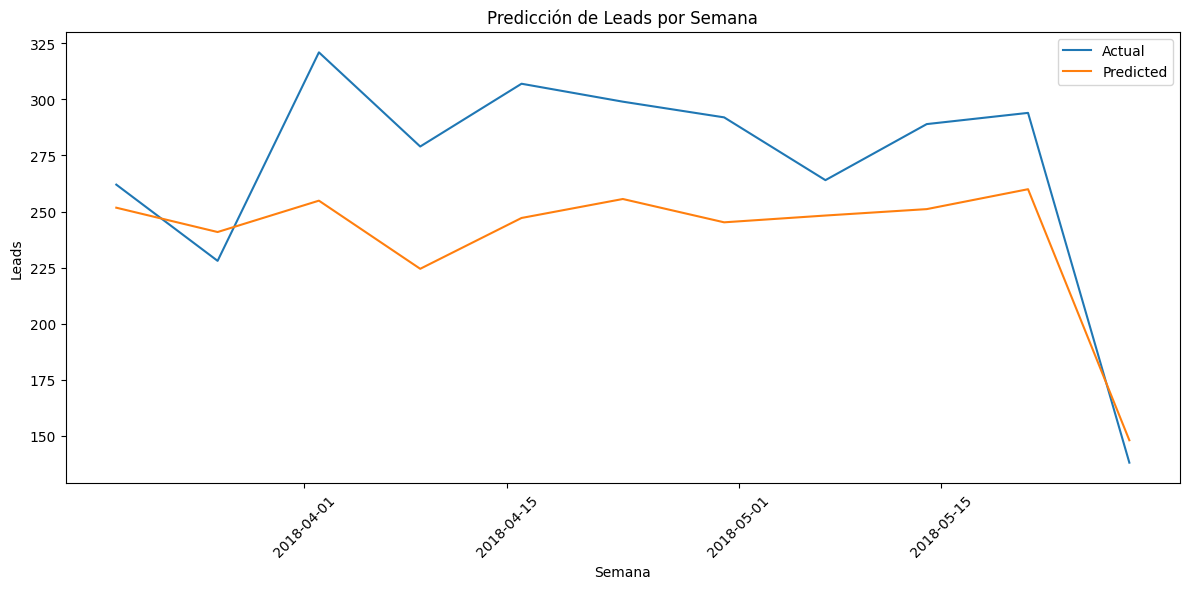

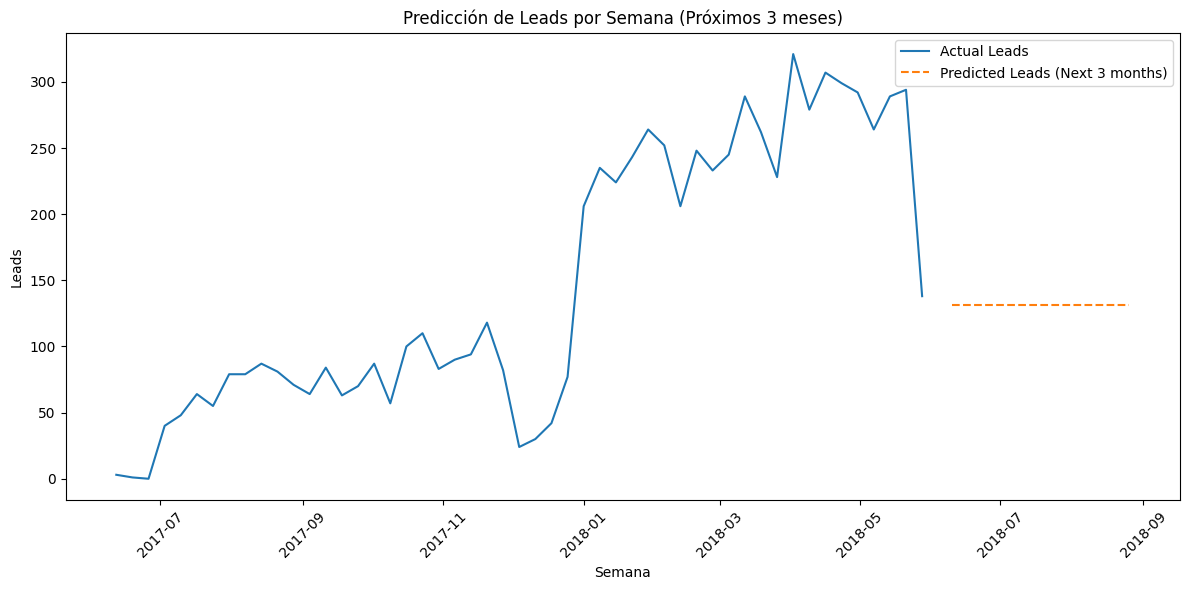

Predicciones para los próximos 3 meses (12 semanas):
         WEEK  PREDICTED_LEADS
0  2018-06-10            131.6
1  2018-06-17            131.6
2  2018-06-24            131.6
3  2018-07-01            131.6
4  2018-07-08            131.6
5  2018-07-15            131.6
6  2018-07-22            131.6
7  2018-07-29            131.6
8  2018-08-05            131.6
9  2018-08-12            131.6
10 2018-08-19            131.6
11 2018-08-26            131.6


In [189]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Asegurarse de que las columnas booleanas sean de tipo int
source_columns = [col for col in df.columns if col.startswith('LEAD_SOURCE_')]
df[source_columns] = df[source_columns].astype(int)

# Crear una columna de semana
df['WEEK'] = df['FIRST_CONTACT_DATE'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por semana y sumar por cada fuente de lead
weekly_data = df.groupby('WEEK')[source_columns].sum().reset_index()

# La variable objetivo será la suma total de leads por semana
weekly_data['TOTAL_LEADS'] = weekly_data[source_columns].sum(axis=1)

# Separar variables predictoras y target
X = weekly_data[source_columns]
y = weekly_data['TOTAL_LEADS']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Entrenar el modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicción y evaluación
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
print(f"RMSE: {rmse:.2f}")

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

# Visualizar resultado
plt.figure(figsize=(12, 6))
plt.plot(weekly_data['WEEK'][-len(y_test):], y_test.values, label='Actual')
plt.plot(weekly_data['WEEK'][-len(y_test):], y_pred, label='Predicted')
plt.xticks(rotation=45)
plt.title("Predicción de Leads por Semana")
plt.xlabel("Semana")
plt.ylabel("Leads")
plt.legend()
plt.tight_layout()
plt.show()

# Estimar los próximos 3 meses (12 semanas)
# Crear las fechas para las próximas 12 semanas
last_week = weekly_data['WEEK'].max()  # Última semana del dataset actual
future_weeks = pd.date_range(start=last_week, periods=13, freq='W')[1:]  # Excluir la última semana ya presente

# Crear un DataFrame para las próximas semanas
future_data = pd.DataFrame(future_weeks, columns=['WEEK'])

# Aquí se debe definir cómo se generarán las variables predictoras para las nuevas semanas
# En este ejemplo, no tenemos los valores reales de las fuentes de leads, así que puedes hacer una suposición
# o usar el promedio o tendencia para las nuevas semanas.

# Suponiendo que tomamos los valores promedio de las columnas `source_columns` para las futuras semanas
avg_sources = weekly_data[source_columns].mean().values  # Promedio de las columnas de fuentes de leads
future_data[source_columns] = [avg_sources] * len(future_data)  # Asumir promedio para las próximas semanas

# Realizar las predicciones para las próximas semanas
future_predictions = model.predict(future_data[source_columns])

# Mostrar las predicciones
future_data['PREDICTED_LEADS'] = future_predictions

# Visualizar las predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(weekly_data['WEEK'], weekly_data['TOTAL_LEADS'], label='Actual Leads')  # Datos históricos
plt.plot(future_data['WEEK'], future_data['PREDICTED_LEADS'], label='Predicted Leads (Next 3 months)', linestyle='--')
plt.xticks(rotation=45)
plt.title("Predicción de Leads por Semana (Próximos 3 meses)")
plt.xlabel("Semana")
plt.ylabel("Leads")
plt.legend()
plt.tight_layout()
plt.show()

# Imprimir las predicciones futuras
print("Predicciones para los próximos 3 meses (12 semanas):")
print(future_data[['WEEK', 'PREDICTED_LEADS']])


### Holt-Winters para cada fuente de leads

MAE: 35.61
RMSE: 40.71
MAPE: 12.52%


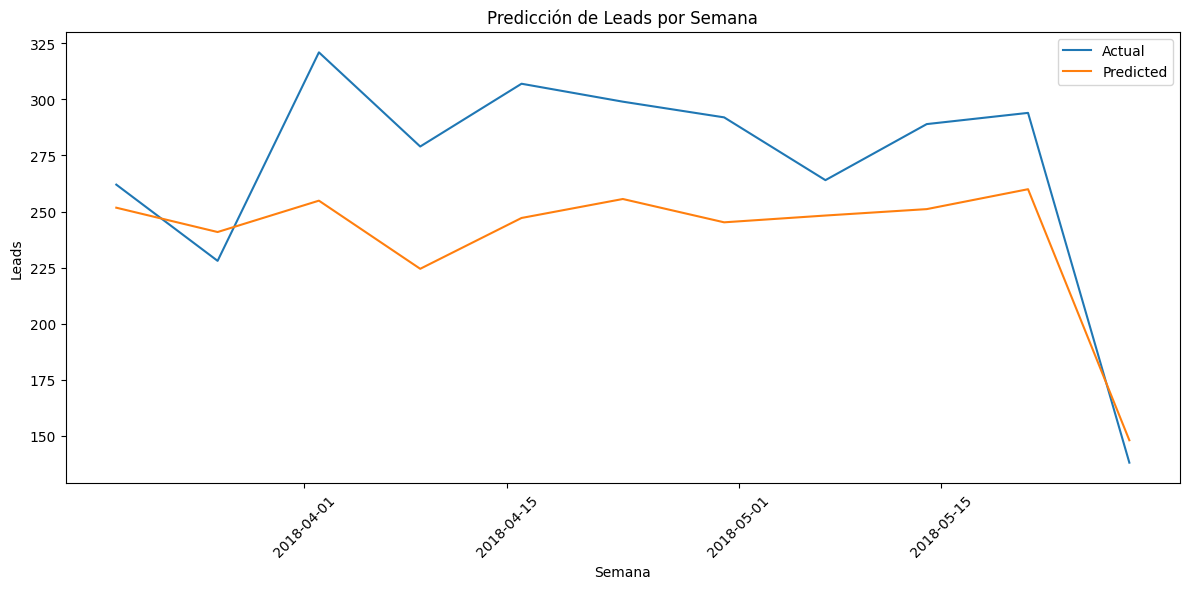

c:\Users\BETAN\Desktop\Mamasita RIKA\Cobre\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\BETAN\Desktop\Mamasita RIKA\Cobre\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


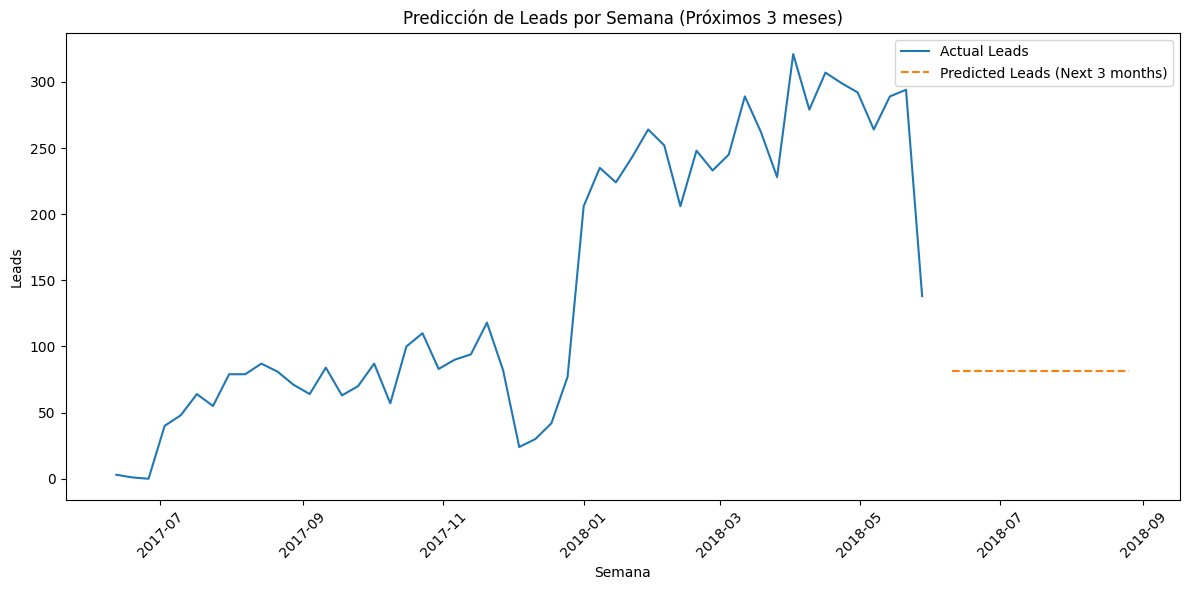

Predicciones para los próximos 3 meses (12 semanas):
         WEEK  PREDICTED_LEADS
0  2018-06-10            81.41
1  2018-06-17            81.41
2  2018-06-24            81.41
3  2018-07-01            81.41
4  2018-07-08            81.41
5  2018-07-15            81.41
6  2018-07-22            81.41
7  2018-07-29            81.41
8  2018-08-05            81.41
9  2018-08-12            81.41
10 2018-08-19            81.41
11 2018-08-26            81.41


In [190]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

# Asegurarse de que las columnas booleanas sean de tipo int
source_columns = [col for col in df.columns if col.startswith('LEAD_SOURCE_')]
df[source_columns] = df[source_columns].astype(int)

# Crear una columna de semana
df['WEEK'] = df['FIRST_CONTACT_DATE'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por semana y sumar por cada fuente de lead
weekly_data = df.groupby('WEEK')[source_columns].sum().reset_index()

# La variable objetivo será la suma total de leads por semana
weekly_data['TOTAL_LEADS'] = weekly_data[source_columns].sum(axis=1)

# Separar variables predictoras y target
X = weekly_data[source_columns]
y = weekly_data['TOTAL_LEADS']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Entrenar el modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicción y evaluación
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
print(f"RMSE: {rmse:.2f}")

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

# Visualizar resultado
plt.figure(figsize=(12, 6))
plt.plot(weekly_data['WEEK'][-len(y_test):], y_test.values, label='Actual')
plt.plot(weekly_data['WEEK'][-len(y_test):], y_pred, label='Predicted')
plt.xticks(rotation=45)
plt.title("Predicción de Leads por Semana")
plt.xlabel("Semana")
plt.ylabel("Leads")
plt.legend()
plt.tight_layout()
plt.show()

# Estimar los próximos 3 meses (12 semanas)
# Crear las fechas para las próximas 12 semanas
last_week = weekly_data['WEEK'].max()  # Última semana del dataset actual
future_weeks = pd.date_range(start=last_week, periods=13, freq='W')[1:]  # Excluir la última semana ya presente

# Crear un DataFrame para las próximas semanas
future_data = pd.DataFrame(future_weeks, columns=['WEEK'])

# Usaremos ARIMA y Holt-Winters para predecir cada una de las columnas de fuentes de leads

# Para cada fuente de lead, aplicaremos ARIMA o Holt-Winters

# 1. ARIMA para cada fuente de leads
arima_models = {}
for col in source_columns:
    # Ajustamos el modelo ARIMA (usamos p=1, d=1, q=1 por defecto, se puede ajustar)
    arima_model = ARIMA(weekly_data[col], order=(1, 1, 1))  # p=1, d=1, q=1
    arima_fit = arima_model.fit()

    # Guardamos el modelo
    arima_models[col] = arima_fit

    # Realizamos las predicciones para las próximas semanas
    future_predictions_arima = arima_fit.forecast(steps=12)  # Predicción para 12 semanas
    future_data[col] = future_predictions_arima

# 2. Holt-Winters para cada fuente de leads
holt_winters_models = {}
for col in source_columns:
    # Ajustamos el modelo Holt-Winters (Triple Exponential Smoothing)
    hw_model = ExponentialSmoothing(weekly_data[col], trend='add', seasonal='add', seasonal_periods=12)
    hw_fit = hw_model.fit()

    # Guardamos el modelo
    holt_winters_models[col] = hw_fit

    # Realizamos las predicciones para las próximas semanas
    future_predictions_hw = hw_fit.forecast(steps=12)
    future_data[col] = future_predictions_hw

# Ahora, hacemos la predicción del modelo RandomForest usando las predicciones de ARIMA y Holt-Winters
future_predictions = model.predict(future_data[source_columns])

# Mostrar las predicciones
future_data['PREDICTED_LEADS'] = future_predictions

# Visualizar las predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(weekly_data['WEEK'], weekly_data['TOTAL_LEADS'], label='Actual Leads')  # Datos históricos
plt.plot(future_data['WEEK'], future_data['PREDICTED_LEADS'], label='Predicted Leads (Next 3 months)', linestyle='--')
plt.xticks(rotation=45)
plt.title("Predicción de Leads por Semana (Próximos 3 meses)")
plt.xlabel("Semana")
plt.ylabel("Leads")
plt.legend()
plt.tight_layout()
plt.show()

# Imprimir las predicciones futuras
print("Predicciones para los próximos 3 meses (12 semanas):")
print(future_data[['WEEK', 'PREDICTED_LEADS']])


## 🧮 Forecast with ARIMA

In [191]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare time series
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# Fit ARIMA model (adjust p,d,q as needed)
model = ARIMA(df['y'], order=(1,1,1))
model_fit = model.fit()

# Forecast next 12 steps
forecast = model_fit.forecast(steps=12)
print(forecast)

KeyError: 'ds'